In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
import os

## Import datasets

In [2]:
def import_datasets(path: str) -> pd.DataFrame:
    x_train = pd.read_feather(os.path.join(path, 'x_train.feather'))
    y_train = pd.read_csv(os.path.join(path, 'y_train.csv'), index_col=False, header=0)
    y_train = y_train['isFraud']
    x_test = pd.read_feather(os.path.join(path, 'x_test.feather'))
    y_test = pd.read_csv(os.path.join(path, 'y_test.csv'), index_col=False, header=0)
    y_test = y_test['isFraud']

    return x_train, y_train, x_test, y_test

In [3]:
x_train, y_train, x_test, y_test = import_datasets('../data')

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442903 entries, 0 to 442902
Columns: 228 entries, TransactionAmt to hour_of_day
dtypes: float64(184), int32(30), int64(14)
memory usage: 719.7 MB


## Train model

In [5]:
def light_gbm_train(x_train: pd.DataFrame, y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame):
    clf = lgb.LGBMClassifier(
        learning_rate=0.02, random_state=42, colsample_bytree=0.4,max_depth=12, 
        n_estimators=2000, subsample=0.4, early_stopping_rounds=100)

    model = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='auc', verbose=10)

    return model

In [6]:
model = light_gbm_train(x_train, y_train, x_test, y_test)

c:\Users\Codrin\.virtualenvs\CIS_Fraud_Detection-LG0CXV5L\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[10]	valid_0's auc: 0.844142	valid_0's binary_logloss: 0.131107
[20]	valid_0's auc: 0.847087	valid_0's binary_logloss: 0.123556
[30]	valid_0's auc: 0.849517	valid_0's binary_logloss: 0.118802
[40]	valid_0's auc: 0.851088	valid_0's binary_logloss: 0.11518
[50]	valid_0's auc: 0.853382	valid_0's binary_logloss: 0.112322
[60]	valid_0's auc: 0.856276	valid_0's binary_logloss: 0.110214
[70]	valid_0's auc: 0.857916	valid_0's binary_logloss: 0.108536
[80]	valid_0's auc: 0.859707	valid_0's binary_logloss: 0.107038
[90]	valid_0's auc: 0.861228	valid_0's binary_logloss: 0.105951
[100]	valid_0's auc: 0.862386	valid_0's binary_logloss: 0.105001
[110]	valid_0's auc: 0.86381	valid_0's binary_logloss: 0.104237
[120]	valid_0's auc: 0.866578	valid_0's binary_logloss: 0.103424
[130]	valid_0's auc: 0.86903	valid_0's binary_logloss: 0.102689
[140]	valid_0's auc: 0.870979	

## Visualize results using auc metric

In [7]:
def light_gbm_performance(model, x_test: pd.DataFrame, y_test: pd.DataFrame) -> float:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

    sns.lineplot(x=fpr, y=tpr)
    plt.show()

    print('Area under roc {}'.format(auc(fpr, tpr)))

    _, ax = plt.subplots(figsize=(10, 12), dpi=80)
    lgb.plot_importance(
        model,
        height=0.75,
        importance_type="gain",
        max_num_features=50,
        ax=ax,
    )
    plt.show()

    return auc(fpr, tpr)

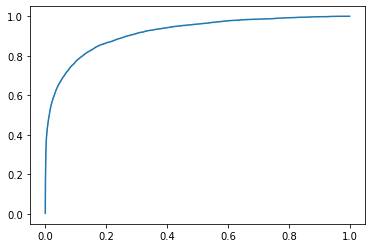

Area under roc 0.9166839833628754


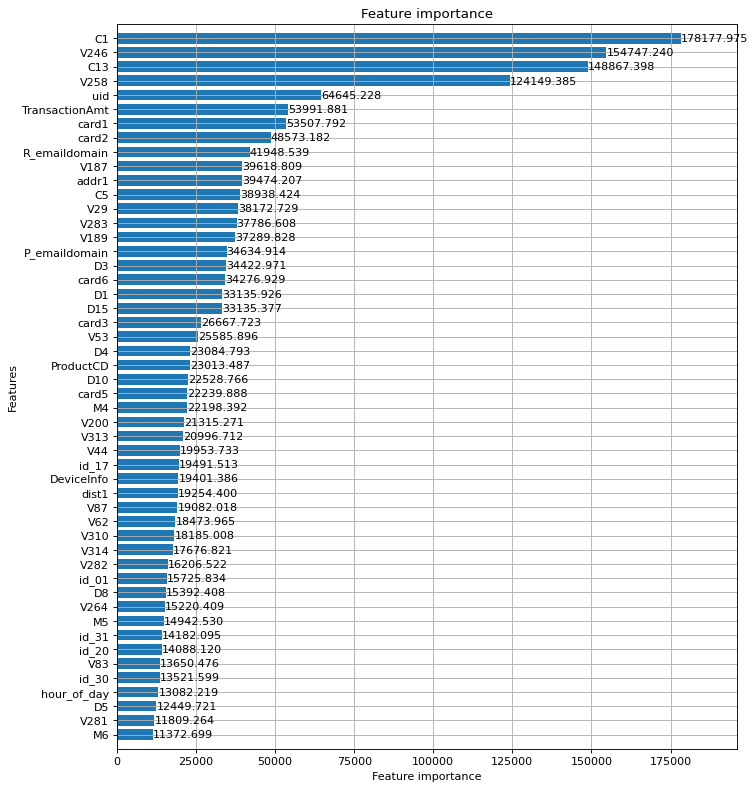

0.9166839833628754

In [8]:
light_gbm_performance(model, x_test, y_test)

## Saving model

In [9]:
model.booster_.save_model('../models/light_gbm.txt')